# Benchmark: Brownian motion
> We show how to use our approach to study Brownian motion trajectories with changes.

In [ ]:
#| hide
from step.data import *
from step.models import *
from step.utils import *
from step.baselines import diffusion_coefficient_tamsd

from tqdm.auto import tqdm
from fastai.vision.all import *

The main goal is to characterize heterogeneous diffusion processes without any kind of prior konwledge. To do so, we predict the diffusion coefficient at every time step, which naturally highlights potential changes in the behaviour along the trajectories. This allows us to obtain a deeper understanding of the underlying physical systems that drive the dynamics. 

In the following analysis, we provide a thorough characterization of the model performance in terms of the segment lengths, the number of segments, the position of the change points, the differences between the segments along a trajectory, and the amount of localization noise that we may have.

# Load the model
First of all, we need to load a trained model with which to perform the analysis.

::: {.callout-note}
We refer to the [model training tutorial](https://borjarequena.github.io/step/tutorials/00_model_training.html) for details about how to train and save your models.
:::

To load the models within a `Leaner`, we need to provide some data loaders. However, we will use the model to study various scenarios, so we provide an empty dataloader and load the different data sets as we need them.

In [ ]:
dim = 2
dls = DataLoaders.from_dsets([], []) # Empty train and validation datasets
model = XResAttn(dim, n_class=1, stem_szs=(64,), conv_blocks=[1, 1, 1],
                 block_szs=[128, 256, 512], pos_enc=False,
                 n_encoder_layers=4, dim_ff=512, nhead_enc=8,
                 linear_layers=[], norm=False, yrange=(-3.1, 3.1))
model.to(default_device())
learn_diff = Learner(dls, model, loss_func=L1LossFlat(), model_dir=MODEL_PATH)

Now we can load the trained model weights.

In [ ]:
learn_diff.load(f'xresattn_bm_{dim}d_1_to_4cp')
learn_diff.model.eval();

::: {.callout-warning}
It is very important to define the model exactly with the same layers as we did during training. Otherwise, we won't be able to load the trained parameters!
:::

# Pointwise prediction error

We study the overall performance of the method over heterogeneous Brownian motion trajectories. We look at the performance as function of the segment length and its resilience to noise.

We compare our approach with a reference method based on the time-averaged mean squared displacement (TA-MSD) (see [baselines]()). However, since this method cannot account for any heterogeneity in the trajectories, we provide it with the pre-segmented trajectories. This provides it with a massive advantage and, thus, we also pass the pre-cut segments through our model. 

With this segment-wise analysis, we can easily study the performance of all the methods as function of the segment lengths. 

## Generate the data

To evaluate the different methods, we need a proper test set. We can generate one in the same way that we genereate the train set in the [model training tutorial](https://borjarequena.github.io/step/tutorials/00_model_training.html).

::: {.callout-note}
Skip the data generation if you already have a test set!
:::

In [ ]:
# OPTIONAL: create the test set. Don't need to run this cell if it already exists.
N_per_set, max_t, dim = 12000, 200, 2
Ds = np.logspace(-3, 3, 1000) 
cps = [1, 2, 3, 4]
ds_fun = partial(create_bm_segmentation_dataset,
                 max_t=max_t, dim=dim, Ds=Ds, save=False)
datasets = [ds_fun(N_per_set, n_change_points=n_cp) for n_cp in cps]
ds = combine_datasets(datasets)
save_path = DATA_PATH/get_bmds_fname(f"{min(cps)}_to_{max(cps)}_test", max_t, dim)
ds.to_pickle(save_path)

Load the test set.

In [ ]:
# Skip this cell if you just generated it.
ds_name = '1_to_4_test'
ds = load_dataset(n_change=ds_name, dim=dim, bm=True)

We also load the data as data loaders with `split_pct=1` (all data for validation). This allows us to loop over batches much more easily setting `shuffle=False`.

In [ ]:
bs = 200
dls = get_segmentation_dls(target='y_exp', dim=dim, n_change=ds_name,
                           tfm_y=torch.log10, bm=True, bs=bs,
                           shuffle=False, split_pct=1.)
dls.device = default_device()

## Get the predictions

We now perform the predictions of the trajectories as a whole and store them in the dataframe to process them later.

In [ ]:
for i, (x, y) in tqdm(enumerate(dls.valid)):
    pred = to_detach(learn_diff.model(x).squeeze())
    metric = to_detach((learn_diff.model(x).squeeze()-y).abs().mean(-1)) # MAE
    l_pred = np.array([p for p in pred], dtype=object)
    ds.loc[i*bs:(i+1)*bs-1, 'mae'] = metric.numpy()
    ds.loc[i*bs:(i+1)*bs-1, 'pred'] = l_pred

0it [00:00, ?it/s]

With the full-trajectory predictions, we can proceed to perform the segment-wise analysis. We split the trajectories and their predictions by the *true* changepoints. Then, we perform the prediction especifically for each segment with both the model and the TA-MSD method. We choose the standard TA-MSD 2-4 to perform the evaluation.

Let's define some functions to simplify the code.

In [ ]:
def predict(model, x):
    xb = x.unsqueeze(0).to(default_device())
    return to_detach(model(xb).squeeze())

def mean_absolute_error(pred, true): 
    return (pred - true).abs().mean()

def mean_relative_error(pred, true, base=10): 
    error = pred - true
    return (base**error - 1).abs().mean()

Now we can proceed to process the trajectories. The following piece of code is rather chonky so let us give a brief overview. For every trajectory (outer loop), we process each of its segments (inner loop). For every segment, we compute the mean absolute error (MAE) and the mean relative error with the three aforementioned approaches.

In [ ]:
segment_data = []

for i, row in tqdm(ds.iterrows()):
    x, y, pred, cps = row.x, torch.log10(row.y_exp.squeeze()), row.pred, row.cp
    split_x = split_tensor(x.T, cps)
    split_y, split_pred = split_tensor(y, cps), split_tensor(pred, cps)
    
    for j, (seg_x, seg_y, pred_cut) in enumerate(zip(split_x, split_y, split_pred)):
        # Prediction over full trajectory cut with true changepoints
        mae = mean_absolute_error(pred_cut, seg_y)
        rel_err = mean_relative_error(pred_cut, seg_y)
        mae_mean = mean_absolute_error(pred_cut.mean(), seg_y[0])
        rel_err_mean = (10**(pred_cut.mean() - seg_y[0]) - 1).abs()
        
        # Prediction over segment
        pred_segment = predict(learn_diff.model, seg_x - seg_x[0])
        mae_segment = mean_absolute_error(pred_segment, seg_y)
        rel_err_segment = mean_relative_error(pred_segment, seg_y)
        mae_segment_mean = mean_absolute_error(pred_segment.mean(), seg_y[0])
        rel_err_segment_mean = (10**(pred_segment.mean() - seg_y[0]) - 1).abs()
        
        # Prediction over segment with TA-MSD
        pred_tmsd = diffusion_coefficient_tamsd(seg_x)
        mae_tmsd = mean_absolute_error(pred_tmsd, 10**seg_y[0])
        rel_err_tmsd = (pred_tmsd*10**(-seg_y[0]) - 1).abs()
        
        # Save the segment metrics
        segment_data.append({'sample': i, 'segment_idx': j, 'length': len(seg_y),
                             'x': seg_x, 'y': seg_y, 'pred_cut': pred_cut,
                             'pred_segment': pred_segment, 'pred_tmsd': pred_tmsd,
                             'mae': mae, 'rel_err': rel_err, 'mae_mean': mae_mean,
                             'rel_err_mean': rel_err_mean,
                             'mae_segment': mae_segment,
                             'rel_err_segment': rel_err_segment,
                             'mae_segment_mean': mae_segment_mean,
                             'rel_err_segment_mean': rel_err_segment_mean,
                             'mae_tmsd': mae_tmsd,
                             'rel_err_tmsd': rel_err_tmsd})
segment_ds = pd.DataFrame.from_records(segment_data)

0it [00:00, ?it/s]

Finally, we save all the data for its posterior post-processing. It is extremely heavy and slow :D

In [ ]:
segment_ds.to_pickle(DATA_PATH/"segment_analysis_test.pkl")

In [ ]:
segment_ds = pd.read_pickle(DATA_PATH/"segment_analysis_test.pkl")

## Compute the metrics

We are interested in the errors performed by each method as a function of the segment length.

In [ ]:
lengths = segment_ds.length.unique().astype(int)
lengths.sort()

metrics = ['err', 'err_mean', 'err_segment', 'err_segment_mean', 'err_tmsd']
metric_by_length = {m: {'mean': [], 'sem': [], 'global': None} for m in metrics}

for m in metrics:
    means = [getattr(segment_ds, f"rel_{m}")[segment_ds.length == l].mean()
             for l in lengths]
    sems = [getattr(segment_ds, f"rel_{m}")[segment_ds.length == l].sem()
            for l in lengths]
        
    metric_by_length[m]['mean'] = np.array(means)
    metric_by_length[m]['sem'] = np.array(sems)
    metric_by_length[m]['global'] = ((getattr(segment_ds,
                                              f"rel_{m}")*segment_ds.length).sum() /
                                      segment_ds.length.sum())

We save all these metrics to plot them nicely later.

In [ ]:
figure_name = "relative_error_segment_length"
plot_data_path = (FIG_PATH/figure_name).with_suffix(".pkl")

with open(plot_data_path, 'wb') as f:
    pickle.dump(metric_by_length, f, protocol=pickle.HIGHEST_PROTOCOL)

## Plot the data

Let's start by loading the data for the plot.

In [ ]:
figure_name = "relative_error_segment_length"
plot_data_path = (FIG_PATH/figure_name).with_suffix(".pkl")

In [ ]:
with open(plot_data_path, 'rb') as f:
    metric_by_length = pickle.load(f)

Ready to go! Format as you please.

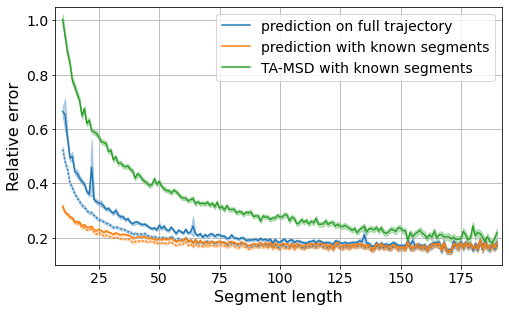

In [ ]:
#| code-fold: true
labels = ['prediction on full trajectory', 'prediction with known segments', 'TA-MSD with known segments']
lengths = np.arange(10, 191)

plt.figure(figsize=(8, 4.75))
for i, m in enumerate(metric_by_length.keys()): 
    linestyle = '-' if i%2 == 0 else 'dotted'
    mean, sem = metric_by_length[m]['mean'], metric_by_length[m]['sem']
    label = labels[i//2] if i%2 == 0 else None
    plt.plot(lengths, mean, linestyle=linestyle, color=f'C{i//2}', label=label)
    plt.fill_between(lengths, mean - sem, mean + sem, color=f'C{i//2}', alpha=0.3)

plt.legend(fontsize=14)
plt.grid()
plt.xlim([7, 192])
plt.ylim([0.1, 1.05])
plt.tick_params(labelsize=14)
plt.xlabel("Segment length", fontsize=16)
plt.ylabel("Relative error", fontsize=16);
# plt.savefig(FIG_PATH/f"{figure_name}.pdf", bbox_inches="tight")

# Resilience to noise

As a final test for the model, we assess its resilience to localization noise. In order to perform the characterization, we use the noiseless dataset with which we have already characterized the effect of the segment length and we add localization noise to the trajectories. We sample the noise from a normal distribution $\mathcal{N}(0,\sigma_{\text{noise}})$ with different values of $\sigma_{\text{noise}}$. 

## Generate the data

We start by taking the dataset and performing inference with various noise levels.

In [ ]:
ds_name = '1_to_4_test'
ds = load_dataset(n_change=ds_name, dim=dim, bm=True)

In [ ]:
ds['y'] = ds['y_exp'].apply(torch.squeeze)
ds['y_log'] = ds['y'].apply(torch.log10)
ds['D'] = ds['exps']
ds['D_log'] = ds['exps'].apply(torch.log10)
# ds['cp'] = ds['cp'].apply(lambda x: x.numpy())
ds = ds.drop(columns=['y_mod', 'y_exp', 'models', 'exps'])

In [ ]:
bs = 400
dls = get_segmentation_dls(target='y_exp', dim=dim, n_change=ds_name, tfm_y=torch.log10, bm=True, 
                           bs=bs, shuffle=False, split_pct=1.)
dls.device = default_device()

To perform a first evaluation, we consider different noise levels in logarithmic scale.

In [ ]:
noise_levels = [-6, -5, -4, -3, -2, -1, 0]

We now perform the predictions on the trajectories at the different noise levels. This will give us an idea about the noise we can handle.  

In [ ]:
for noise in noise_levels:
    for i, (x, _) in enumerate(tqdm(dls.valid)):
        x += 10**(noise)*torch.randn_like(x)
        pred = to_detach(learn_diff.model(x).squeeze())
        l_pred = np.array([p for p in pred], dtype=object)
        ds.loc[i*bs:(i+1)*bs-1, f'pred_{noise}'] = l_pred

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

  0%|          | 0/120 [00:00<?, ?it/s]

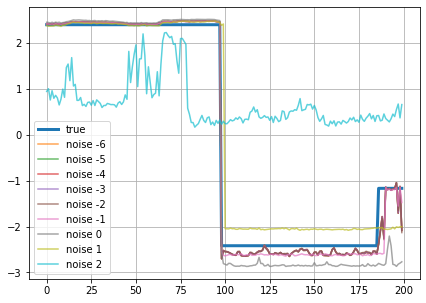

In [ ]:
idx = 0
plt.figure(figsize=(7,5))
plt.plot(ds.loc[idx, 'y_log'], linewidth=3., label='true')
for n in noise_levels: 
    plt.plot(ds.loc[idx, f'pred_{n}'], alpha=0.7, label=f'noise {n}')
plt.legend()
plt.grid()

We can also consider the prediction by segments and compare it to TA-MSD, which cannot account for changes in D. In this analysis, we consider various noise levels for each trajectory and we predict the diffusion coefficient for each of them. 

In [ ]:
noise_samples = 128
noise_max, noise_min = 0, -6
noise_range = noise_max - noise_min
noise_traj = torch.rand(ds.shape[0], noise_samples)*noise_range + noise_min
shape = (ds.shape[0], 200, noise_traj.shape[1])

pred_by_noise, pred_seg_by_noise = torch.zeros(shape), torch.zeros(shape) 
pred_seg_mean_by_noise, pred_tamsd_by_noise = torch.zeros(shape), torch.zeros(shape)
for i, (x, cps) in tqdm(ds[['x','cp']].iterrows()):
    noise = torch.randn(noise_samples, *x.T.shape)*10**noise_traj[i].unsqueeze(-1).unsqueeze(-1)
    noisy_x = x.T.unsqueeze(0) + noise
    noisy_x -= noisy_x[:, 0].unsqueeze(1)
    split_x = split_tensor(noisy_x.transpose(1, 0), cps)
    
    pred_by_noise[i] = to_detach(learn_diff.model(noisy_x.cuda()).squeeze()).T
    
    pred_seg, pred_seg_mean, pred_tamsd = [], [], []
    for seg_x in split_x:
        seg_x = (seg_x - seg_x[0]).transpose(1, 0)
        ones = torch.ones(seg_x.shape[1])
        pred = to_detach(learn_diff.model(seg_x.cuda()).squeeze())
        pred_seg.append(pred)
        pred_seg_mean.append(pred.mean(-1).unsqueeze(1)*ones.unsqueeze(0))
        pred_tamsd.append(torch.stack([ones*diffusion_coefficient_tamsd(s) for s in seg_x]))
        
    pred_seg_by_noise[i] = torch.cat(pred_seg, axis=-1).T
    pred_seg_mean_by_noise[i] = torch.cat(pred_seg_mean, axis=-1).T
    pred_tamsd_by_noise[i] = torch.cat(pred_tamsd, axis=-1).T

0it [00:00, ?it/s]

With the predictions, let's compute the error performed at every point as a function of the noise to signal ratio.

In [ ]:
y = torch.stack([t for t in ds['y_log'].values])
rel_noise = noise_traj.unsqueeze(1) - y.unsqueeze(-1)
predictions = dict(zip(['full', 'seg', 'seg_mean', 'tamsd'],
                       [pred_by_noise, pred_seg_by_noise, pred_seg_mean_by_noise, pred_tamsd_by_noise]))

In [ ]:
errors = {k: p - y.unsqueeze(-1) if k != 'tamsd' else p/(10**y.unsqueeze(-1)) - 1 
          for k, p in predictions.items()} # Already get rel error for tamsd
bins = torch.linspace(rel_noise.min(), rel_noise.max(), 100)

In [ ]:
noise_err, noise_err_std, x, counts = [], [], [], []
for low, high in tqdm(zip(bins[:-1], bins[1:])):
    mask = (rel_noise >= low) & (rel_noise <= high)
    x.append((low + high)/2)
    counts.append(mask.float().sum())
    rel_errors = [(10**err[mask] - 1).abs() if k != 'tamsd' else err[mask].abs() 
                  for k, err in errors.items()]
    noise_err.append(tensor([rel_err.mean() for rel_err in rel_errors]))
    noise_err_std.append(tensor([rel_err.std() for rel_err in rel_errors]))
    
noise_err = torch.stack(noise_err)
noise_err_std = torch.stack(noise_err_std)
x = torch.stack(x)
counts = torch.stack(counts)

0it [00:00, ?it/s]

In [ ]:
fig_name = "noise_analysis"
plot_path = (FIG_PATH/fig_name).with_suffix(".pkl")
plot_data = (noise_err, noise_err_std, x, counts)
with open(plot_path, 'wb') as f:
    pickle.dump(plot_data, f, protocol=pickle.HIGHEST_PROTOCOL)

## Plot the data 

In [ ]:
fig_name = "noise_analysis"
plot_path = (FIG_PATH/fig_name).with_suffix(".pkl")
with open(plot_path, 'rb') as f:
    noise_err, noise_err_std, x, counts = pickle.load(f)

In [ ]:
sem = noise_err_std/counts.sqrt().unsqueeze(-1)

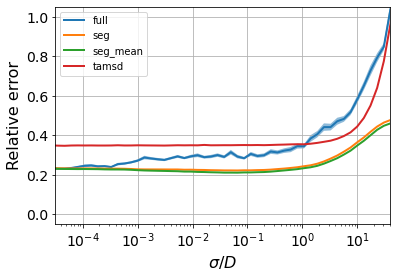

In [ ]:
for err, s, label in zip(noise_err.T, sem.T, predictions.keys()):
    plt.semilogx(10**x, err, '-', linewidth=2., label=label)
    plt.fill_between(10**x, err - s, err + s, alpha=0.5)
plt.grid()
plt.ylim([-0.05, 1.05])
plt.legend()
# plt.xlim([10**(-4.5), 1105])
plt.xlim([10**(-4.5), 40])
plt.tick_params(labelsize=14)
plt.xlabel(r"$\sigma/D$", fontsize=16)
plt.ylabel("Relative error", fontsize=16)
# plt.savefig(FIG_PATH/'Noise resilience analysis.pdf', bbox_inches='tight')

# Effect of the number of segments

An important factor to consider is the number of segments along trajectories. Here, we study the pointwise prediction error for trajectories with various segments of constant length. We consider different numbers of segments and segment lengths.

## Generate the data

First of all, we create our test data. We create our custom methods just for this test, provided that we do not have adhoc functions to generate this kind of data. If we have already created the test set, we can directly load it and skip these cells.

In [ ]:
@delegates(brownian_motion)
def constant_segment_trajectories(N, segment_length, n_change_points=1,
                                  Ds=np.logspace(-3, 3, 1000), **kwargs):
    "Create `N` trajectories with constant segment length."
    n_segments = n_change_points + 1
    max_t = n_segments * segment_length
    segment_D = np.random.choice(Ds, size=(N, n_segments))
    point_D = np.repeat(segment_D, segment_length, axis=-1)[:, None, :]
    bms = brownian_motion(N, max_t, point_D, **kwargs)
    return bms, point_D

def create_constant_segment_dataset(N, segment_length, n_change_points=1, dim=2):
    "Creates a dataset of `N` trajectories with constant segment length."
    df = pd.DataFrame(columns=['dim', 'len', 'seg_len', 'n_cp', 'cp', 'x', 
                               'y', 'y_exp'], dtype=object)
    trajs, labels = constant_segment_trajectories(N, segment_length, 
                                                  n_change_points=n_change_points,
                                                  dim=dim)
    length = trajs.shape[-1]
    cp = np.arange(segment_length, length, segment_length)
    for traj, label in zip(trajs, labels):
        x, y = tensor(traj), tensor(label).squeeze()
        df = df.append({'dim': dim, 'len': length, 'seg_len': segment_length,
                        'n_cp': n_change_points, 'cp': cp, 'x': x, 'y': y,
                        'y_log': torch.log10(y)}, ignore_index=True)
    return df

With these functions, we can easily create our data set. We consider trajectories with none to 10 changepoints and segment lengths of 20 to 60 in intervals of 10.

In [ ]:
N_per_set, segment_lengths, cps = 2000, [20, 30, 40, 50, 60], np.arange(11)
Ds = np.logspace(-3, 3, 1000) 
datasets = [create_constant_segment_dataset(N_per_set, sl, n_change_points=n_cp) 
            for sl in segment_lengths for n_cp in tqdm(cps)]
ds = combine_datasets(datasets, shuffle=False)

## Get the predictions

With our dataset ready, we can proceed to perform the predictions. We store them in the same dataframe. 

In [ ]:
def make_batch(df, i, bs, col='x'):
    "Return a batch of samples from df."
    samples = [x.transpose(-1, 0) for x in ds.loc[i*bs:(i+1)*bs-1, col]]
    return torch.stack(samples, dim=0)

In [ ]:
bs = 50
n_batch = np.ceil(ds.shape[0]/bs).astype(int)
for i in tqdm(range(n_batch)):
    xb = make_batch(ds, i, bs).to(default_device())
    pred = to_detach(learn_diff.model(xb)).squeeze())
    ds.loc[i*bs:(i+1)*bs-1, 'pred'] = np.array([p for p in pred], dtype=object)

## Compute the metrics

So far, we have characterized the prediction error with various metrics, such as the mean absolute error or the relative error, which focus on the pointwise performance.

However, the pointwise relative error is a rather volatile quantity. For instance, in the case there is a large change between consecutive diffusion coefficients, e.g., from $10^3$ to $10^{-3}$, even if the agent performs a perfect characterization, but fails by a single point, the relative error for the whole trajectory shoots up to $\sim10^6$. Therefore, in order to obtain a better understanding of the actual prediction error, $D_{\text{true}} - D_{\text{pred}}$, we consider the mean prediction of each segment $D_{\text{true}} - \langle D_{\text{pred}}\rangle_{\text{seg}}$. 

In [ ]:
def segment_rel_error(pred, y, cp):
    "Computes the segment-wise relative error. Assumes `pred` and `y` in log10."
    segment_preds = split_tensor(pred, cp)
    segment_means = torch.stack([p.mean() for p in segment_preds])
    true_values = torch.cat([y[0].unsqueeze(0), y[cp]])
    return (10**(segment_means - true_values) - 1).abs().mean()

In [ ]:
# metrics
ds['mae'] = (ds['pred'] - ds['y_log']).abs().apply(torch.mean)
ds['seg_rel_error'] = ds.apply(lambda x: segment_rel_error(x['pred'],
                                                           x['y_log'], x['cp']),
                                                           axis=1)

Save the data for posterior processing.

In [ ]:
ds_path = DATA_PATH/"constant_segment_analysis.pkl"
ds.to_pickle(ds_path)

## Plot the data

Let's see now how the metrics evolve as a function of the number of segments. 

We start by loading the data.

In [ ]:
# Load the data
ds_path = DATA_PATH/"constant_segment_analysis.pkl"
ds = pd.read_pickle(ds_path)

Define some plot functions to keep consistent aesthetics.

In [ ]:
def plot_metric_per_ncp(ds, metric, ylabel=None, figsize=(8, 4.75), fontsize=16, labelsize=14):
    "Plots metric as function of number of change points per segment length."
    segment_lengths, n_cps = ds.seg_len.unique().astype(int), ds.n_cp.unique().astype(int)
    value_per_cp = np.array([getattr(ds, metric)[ds.n_cp == n_cp].mean() for n_cp in n_cps])
    err_per_cp = np.array([getattr(ds, metric)[ds.n_cp == n_cp].sem() for n_cp in n_cps])
    
    plt.figure(figsize=figsize)
    plt.plot(n_cps, value_per_cp, marker='o')
    plt.fill_between(n_cps, value_per_cp - err_per_cp, value_per_cp + err_per_cp, alpha=0.3)
    plt.xlabel("Number of change points", fontsize=fontsize)
    plt.ylabel(metric if ylabel is None else ylabel, fontsize=fontsize)
    plt.grid()
    plt.tick_params(labelsize=14)

def plot_metric_per_length_ncp(ds, metric, ylabel=None, figsize=(8, 4.75), fontsize=16, 
                               labelsize=14, legend_kwargs={}):
    "Plots metric as function of number of change points per segment length."
    segment_lengths, n_cps = ds.seg_len.unique().astype(int), ds.n_cp.unique().astype(int)
    markers = ['o', 's', 'D', 'p']
    plt.figure(figsize=figsize)
    for k, length in enumerate(segment_lengths):
        value_per_cp = np.array([getattr(ds, metric)[(ds.seg_len == length) & (ds.n_cp == n_cp)].mean()
                                 for n_cp in n_cps])
        err_per_cp = np.array([getattr(ds, metric)[(ds.seg_len == length) & (ds.n_cp == n_cp)].sem() 
                               for n_cp in n_cps])
        plt.plot(n_cps, value_per_cp, marker=markers[k], label=f"segment length {length}")
        plt.fill_between(n_cps, value_per_cp - err_per_cp, value_per_cp + err_per_cp, alpha=0.3)
    plt.xlabel("Number of change points", fontsize=fontsize)
    plt.ylabel(metric if ylabel is None else ylabel, fontsize=fontsize)
    plt.grid()
    plt.tick_params(labelsize=14)
    plt.legend(fontsize=labelsize, **legend_kwargs)

We first have a look at the relative error as a function of the number of segments for segment lengths 20, 40, and 60. 

In [ ]:
sub_ds = ds[(ds.seg_len != 30) & (ds.seg_len != 50)]

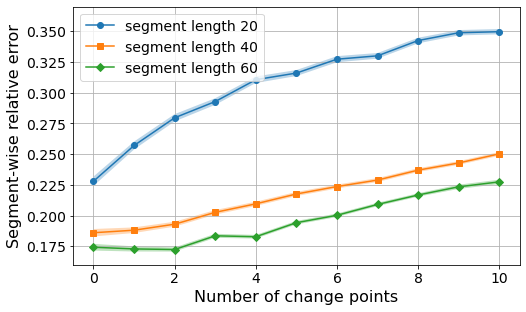

In [ ]:
plot_metric_per_length_ncp(sub_ds, 'seg_rel_error', ylabel="Segment-wise relative error",
                           legend_kwargs={'loc': 'upper left'})
plt.ylim([0.16, 0.37])
plt.savefig(FIG_PATH/"relative_error_num_cp.pdf", bbox_inches="tight")

We observe that having additional segments is, indeed, a source of error, although we see a weak dependency between both quantities. We can identify that the main contribution to the error comes from the segment length, as we had identified before. 

Let's see what happens with the accuracy to identify the different calssification modes. 

In [ ]:
sub_ds = ds[ds.n_cp != 0]

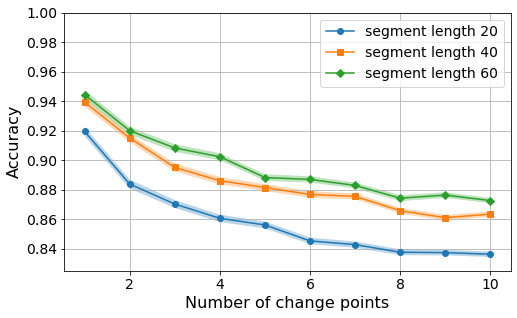

In [ ]:
plot_metric_per_length_ncp(sub_ds, 'detect_rate', ylabel="Accuracy")
plt.ylim([0.825, 1.])
plt.savefig(FIG_PATH/"accuracy_num_cp.pdf", bbox_inches="tight")

In this case, we see that the accuracy stabilizes when we reach a high number of segments. This suggests that, with every new change point, the model incurs a similar error. As the trajectories become longer, both with extra or longer segments, these errors become less relevant.

# Anomalous diffusion from normal diffusion

## Scaled Brownian motion


### Generate the data

In this analysis, we use scaled Brownian motion (SBM) trajectories, which present an aging phenomenon that dicreases the diffusion coefficient with time. 

In [ ]:
n_traj, max_t, exponents, models, dim = 6000, 200, np.array([0.1, 0.5]), [4], 2
trajs = create_trajectories(n_traj, max_t, exponents, models, dim, noise=None)
trajs = tensor(trajs[:, 2:].reshape((n_traj, dim, max_t)).transpose(0, 2, 1))

Let's predict the diffusion coefficient for these trajectories.

In [ ]:
bs = 128
n_batch = np.ceil(n_traj/bs).astype(int)
batches = [trajs[i*bs:(i+1)*bs] for i in range(n_batch)]

In [ ]:
preds = [to_detach(learn_diff.model(xb.cuda()).squeeze()) for xb in batches]
preds = torch.cat(preds, axis=0)

Text(0.5, 0, 't')

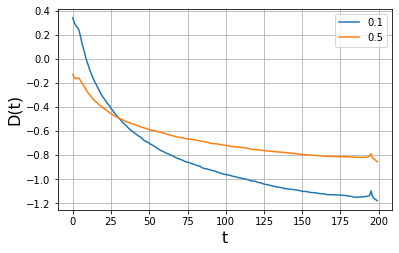

In [ ]:
plt.figure(figsize=(6, 3.7))
plt.plot(preds[:n_traj//2].mean(axis=0), label=exponents[0])
plt.plot(preds[n_traj//2:].mean(axis=0), label=exponents[1])
plt.grid()
plt.legend()
plt.ylabel("D(t)", fontsize=16)
plt.xlabel("t", fontsize=16)

In [ ]:
file_name = "preds_sbm"
data_path = DATA_PATH/file_name
with open(data_path.with_suffix('.pkl'), 'wb') as f:
    pickle.dump(preds, f, protocol=pickle.HIGHEST_PROTOCOL)

## Annealed transit time model

### Generate the data

In [ ]:
n_traj, max_t, sigma, gamma = 10000, 200, 1.16, 1.38
trajs, Ds = create_fixed_attm_trajs(n_traj, max_t, sigma, gamma)
trajs, Ds = tensor(trajs).transpose(2, 1), tensor(Ds)

In [ ]:
bs = 128
n_batch = np.ceil(n_traj/bs).astype(int)
batches = [trajs[i*bs:(i+1)*bs] for i in range(n_batch)]

In [ ]:
preds = [to_detach(learn_diff.model(xb.cuda().float()).squeeze()) for xb in tqdm(batches)]
preds = torch.cat(preds, axis=0)

  0%|          | 0/79 [00:00<?, ?it/s]

In [ ]:
file_name = "preds_attm"
data_path = DATA_PATH/file_name
with open(data_path.with_suffix('.pkl'), 'wb') as f:
    pickle.dump({'pred': preds, 'true': Ds}, f, protocol=pickle.HIGHEST_PROTOCOL)

# Detecting changes

With our proposed method, changes in diffusion properties emerge naturally in the prediction. However, we do not obtain the change point positions explicitly and we require some additional post processing. We use [ruptures](https://centre-borelli.github.io/ruptures-docs/) to find the change points in our predictions. 

In [ ]:
from step.baselines import ruptures_cp

In [ ]:
def get_displacements(x):
    "Returns the displacements."
    return np.sqrt(np.sum(np.diff(x, axis=1)**2, axis=0))

def merge_dict(dict_1, dict_2):
    merge = {}
    for k, v1 in dict_1.items():
        v2 = dict_2.get(k, [])
        if isinstance(v1, Iterable) and isinstance(v2, Iterable):
            merge[k] = [*v1, *v2]
        elif isinstance(v1, Iterable):
            merge[k] = [*v1, v2]
        elif isinstance(v2, Iterable):
            merge[k] = [v1, *v2]
        else:
            merge[k] = [v1, v2]
    return merge

## Generate the data

### Full test set
We will load the test set we created at the beginning of this notebook.

In [ ]:
ds_name = '1_to_4_test'
ds = load_dataset(n_change=ds_name, dim=dim, bm=True)

In [ ]:
bs = 200
dls = get_segmentation_dls(target='y_exp', dim=dim, n_change=ds_name, tfm_y=torch.log10, bm=True, 
                           bs=bs, shuffle=False, split_pct=1.)
dls.device = default_device()

We now perform the predictions of the trajectories as a whole and store them in the dataframe to process them later. 

In [ ]:
for i, (x, y) in tqdm(enumerate(dls.valid)):
    pred = to_detach(learn_diff.model(x).squeeze())
    l_pred = np.array([p for p in pred], dtype=object)
    ds.loc[i*bs:(i+1)*bs-1, 'pred'] = l_pred

In [ ]:
method_pen = {'pred': 2., 'displ': 6.}
methods = list(method_pen.keys())

metrics_method = {m: {} for m in methods}
for _, row in tqdm(ds.iterrows()):
    traj, pred, true_cp = row.x.numpy(), row.pred.numpy(), row.cp.numpy()
    displacements = np.log(get_displacements(traj))

    for m in methods:
        seg_data = (pred if m == 'pred' else displacements if m == 'displ' else None)
        pred_cp = ruptures_cp(seg_data, pen=method_pen[m], min_size=5)
        metrics_method[m] = merge_dict(evaluate_cp_prediction(true_cp, pred_cp), metrics_method[m])

method_mse, method_j_idx = {}, {}
for m, v in metrics_method.items():
    method_mse[m] = np.mean(v['squared_error'])
    tp, fp, fn = np.sum(v['tp']), np.sum(v['fp']), np.sum(v['fn'])
    method_j_idx[m] = jaccard_index(tp, fp, fn)

0it [00:01, ?it/s]

In [ ]:
method_j_idx

{'pred': 0.8124350210797757, 'displ': 0.8202676240208877}

In [ ]:
method_mse

{'pred': 1.3098757594994106, 'displ': 1.488351967532726}

### Single change point

In order to obtain a better insight about the strengths of the methods, we need a more restricted environment where we can better asses the effect of different factors. In this case, we can look at how the difference between diffusion coefficient in consecutive segments affects the performance as well as the change point position.

In [ ]:
Ds = np.logspace(-3, 3, 1000) 
ds = create_bm_segmentation_dataset(50000, dim=dim, Ds=Ds)

In [ ]:
ds['y'] = ds['y_exp'].apply(torch.squeeze)
ds['y_log'] = ds['y'].apply(torch.log10)
ds['D'] = ds['exps']
ds['D_log'] = ds['exps'].apply(torch.log10)
ds['cp'] = ds['cp'].apply(lambda x: x.numpy())
ds = ds.drop(columns=['y_mod', 'y_exp', 'models', 'exps'])

Let's proceed with the predictions! 

In [ ]:
bs = 400
n_batch = np.ceil(ds.shape[0]/bs).astype(int)
for i in tqdm(range(n_batch)):
    xb = torch.stack([x.transpose(-1, 0) for x in ds.loc[i*bs:(i+1)*bs-1, 'x']], dim=0)
    pred = to_detach(learn_diff.model(xb.to(default_device())).squeeze())
    ds.loc[i*bs:(i+1)*bs-1, 'pred'] = np.array([p for p in pred], dtype=object)

  0%|          | 0/125 [00:00<?, ?it/s]

In [ ]:
ds_path = DATA_PATH/"bmds_1change_dim2_with_preds.pkl"

In [ ]:
# ds = pd.read_pickle(ds_path)
# ds['D_diff'] = ds['D_log'].apply(lambda x: (x[1] - x[0]).item())
# ds['D_rel_diff'] = ds['D'].apply(lambda x: (x[1]/x[0] - 1).item())
# ds.to_pickle(ds_path)

In [ ]:
ds = pd.read_pickle(ds_path)

In [ ]:
method_pen = {'pred': 2., 'displ': 6.}#, 'var_5': 10., 'var_10': 10.}
methods = list(method_pen.keys())

metrics_method = {m: {} for m in methods}
for i, row in tqdm(ds.iterrows()):
    traj, pred, true_cp = row.x.numpy(), row.pred.numpy(), row.cp
    displacements = np.log(get_displacements(traj))
    # variances_5 = np.log(swin_var(displacements, win_size=5))
    # variances_10 = np.log(swin_var(displacements, win_size=10))

    for m in methods:
        seg_data = (pred if m == 'pred' else displacements if m == 'displ' else
                    variances_5 if m == 'var_5' else variances_10 if m == 'var_10' else None)
        pred_cp = ruptures_cp(seg_data, pen=method_pen[m], min_size=5)
        metrics = evaluate_cp_prediction(true_cp, pred_cp, changepoint_threshold=5)
        metrics_method[m] = merge_dict(metrics, metrics_method[m])
        for k, v in metrics.items():
            if metrics['tp']:
                ds.loc[i, f'cp_{m}_{k}'] = v[0] if k == 'squared_error' else v
            else:
                ds.loc[i, f'cp_{m}_{k}'] = -1 if k == 'squared_error' else v

method_mse, method_j_idx = {}, {}
for m, v in metrics_method.items():
    method_mse[m] = np.mean(v['squared_error'])
    tp, fp, fn = np.sum(v['tp']), np.sum(v['fp']), np.sum(v['fn'])
    method_j_idx[m] = jaccard_index(tp, fp, fn)

0it [00:00, ?it/s]

In [ ]:
method_j_idx, method_mse

({'pred': 0.8333494778851929, 'displ': 0.7963921392139214},
 {'pred': 0.6803905614320586, 'displ': 0.6163644925829997})

In [ ]:
# ds.to_pickle(ds_path)

In [ ]:
bins_D_diff = np.linspace(-6, 6, 100)

In [ ]:
j_idx_by_diff = {m: [] for m in methods}
mse_by_diff = {m: [] for m in methods}

for low, high in zip(bins_D_diff[:-1], bins_D_diff[1:]):
    mask = (ds.D_diff >= low) & (ds.D_diff < high)
    for m in methods:
        tp = ds.loc[mask, f'cp_{m}_tp'].sum()
        fp = ds.loc[mask, f'cp_{m}_fp'].sum()
        fn = ds.loc[mask, f'cp_{m}_fn'].sum()
        j_idx_by_diff[m].append(jaccard_index(tp, fp, fn))
        
        mask_mse = mask & (ds.loc[:, f'cp_{m}_tp'] == 1)
        mse_by_diff[m].append(ds.loc[mask_mse, f'cp_{m}_squared_error'].mean())

Text(0, 0.5, 'Jaccard index')

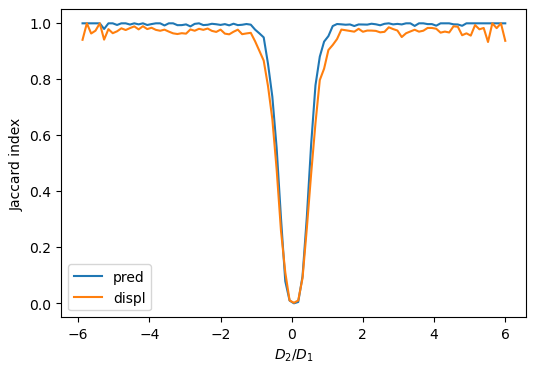

In [ ]:
plt.figure(figsize=(6, 4))
plt_x = bins_D_diff[:-1] + np.diff(bins_D_diff)
for m in methods:
    plt.plot(plt_x, j_idx_by_diff[m], label=m)
plt.legend()
plt.xlabel(r"$D_2/D_1$")
plt.ylabel("Jaccard index")